In [2]:

import numpy as np
import pandas as pd 


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import random_split, DataLoader

In [4]:
imag_folder = '/kaggle/input/files1/Malaria Cells/'
transform = transforms.Compose( [
     transforms.Resize([128,128]),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])
train_dataset = ImageFolder(imag_folder + 'training_set', transform=transform)
testing_set = ImageFolder(imag_folder + 'testing_set', transform=transform)

In [5]:
print('train_set size = ', len(train_dataset))
print('testing_set size = ', len(testing_set))

train_set size =  27558
testing_set size =  15832


In [6]:
img, label = train_dataset[1000]
print(img.shape, label)

torch.Size([3, 128, 128]) 0


In [7]:
train_dataset.classes

['Parasitized', 'Uninfected']

In [8]:
testing_set.classes

['Parasitized', 'Uninfected']

In [9]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils
%matplotlib inline

def show_image(images, label):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(vutils.make_grid(images, nrow=10).permute(1, 2, 0))
    ax.set_title(label) 
    plt.show()

<Figure size 3000x3000 with 0 Axes>

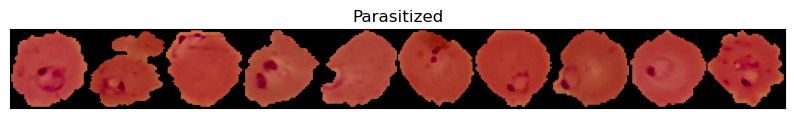

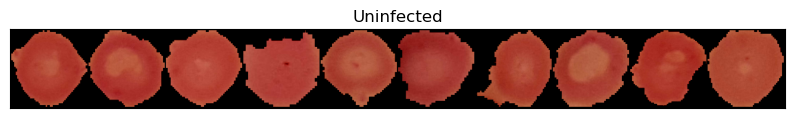

<Figure size 640x480 with 0 Axes>

In [10]:
class_labels = train_dataset.classes

plt.figure(figsize=(30, 30)) 

for i, class_label in enumerate(class_labels):
    class_indices = [j for j, label in enumerate(train_dataset.targets) if label == class_labels.index(class_label)]
    class_images = [train_dataset[j][0] for j in class_indices[:10]] 

    show_image(class_images, class_label) 

plt.tight_layout()
plt.show()


In [11]:
batch_size=50

train_ds = DataLoader(train_dataset, batch_size, shuffle=True,)

In [12]:
from torchvision.utils import make_grid

def show_batch(dl):    
    for images, label in dl:
        fig, ax = plt.subplots(figsize=(10,10))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, 10).permute(1,2,0))
        break
        

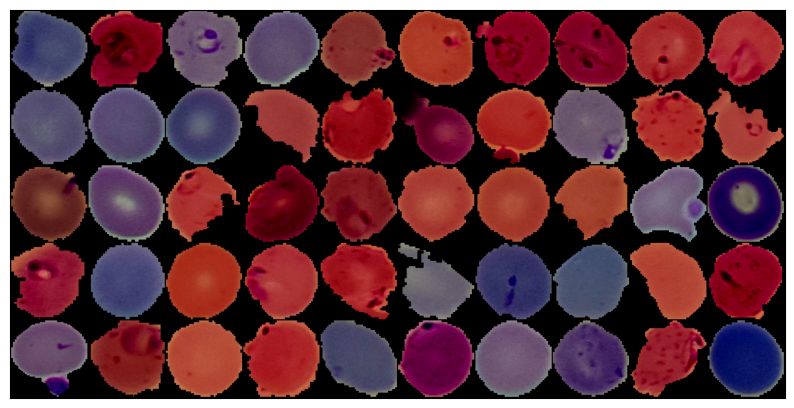

In [14]:
show_batch(train_ds)

In [15]:
simple_model = nn.Sequential(
    
    nn.Conv2d(3, 32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    
    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(128, 128, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    
    nn.Conv2d(128, 256, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(256, 256, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    
    
)

In [16]:
for image, label in train_ds:
    print(image.shape)
    out = simple_model(image)
    print(out.shape)
    break

torch.Size([50, 3, 128, 128])
torch.Size([50, 256, 16, 16])


In [17]:
class ConNet(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
         
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc1 = nn.Linear(256*16*16, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 2)
        self.drop = nn.Dropout2d(0.2)
        
    def forward(self,x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = out.view(out.size(0), -1)   
        out = self.fc1(out)
        out = F.relu(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.drop(out)
        out = self.fc3(out)
        
        return out

In [18]:
loss_fun = nn.CrossEntropyLoss()
model = ConNet()
opt = torch.optim.Adam(model.parameters(), lr =0.001)

In [19]:
epochs = 10
all_losses = []

device = ("cuda" if torch.cuda.is_available else "cpu")
model.to(device)

for epoch in range(epochs):
    
    for i, (images, labels) in enumerate(train_ds):
        images = images.to(device)
        labels = labels.to(device)
        yb = model(images)
        loss = loss_fun(yb, labels)
        opt.zero_grad()
        loss.backward()
        opt.step()
        all_losses.append(loss.item())
        
    print(f"Epoch is {epoch+1} and loss is {loss.item()}")
        
    

/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch is 1 and loss is 0.466484934091568
Epoch is 2 and loss is 0.12505537271499634
Epoch is 3 and loss is 0.030804812908172607
Epoch is 4 and loss is 0.17967697978019714
Epoch is 5 and loss is 0.07534357905387878
Epoch is 6 and loss is 0.26139864325523376
Epoch is 7 and loss is 0.031097032129764557
Epoch is 8 and loss is 0.008956670761108398
Epoch is 9 and loss is 0.041761185973882675
Epoch is 10 and loss is 0.005782905034720898


In [20]:
testing_dataset = ImageFolder(imag_folder + 'testing_set', transform=transform)
test_ds = DataLoader(testing_dataset, batch_size*2)

In [39]:
total = 0
correct = 0

for i, (images,labels )in enumerate(test_ds):        
    img = images.to(device)    
    preds = model(img)
    for j in range(len(preds)):
        total += 1
        ypred = preds[j].argmax()
        ypred = ypred.cpu()
        if (labels[j].numpy() == ypred.numpy()):
            correct += 1
            
print(f"Total no. of records {total}") 
print(f"Accuracy score is {correct/total}")
     


/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


1
Total no. of records 15832
Accuracy score is 0.976566447700859


In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

torch.save(model , 'model.pth')

In [ ]:
device = ("cuda" if torch.cuda.is_available else "cpu")
model.to(device)

for i, (inputs, labels) in enumerate(train_ds):
        inputs = inputs.to(device)
        labels = labels.to(device)

/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


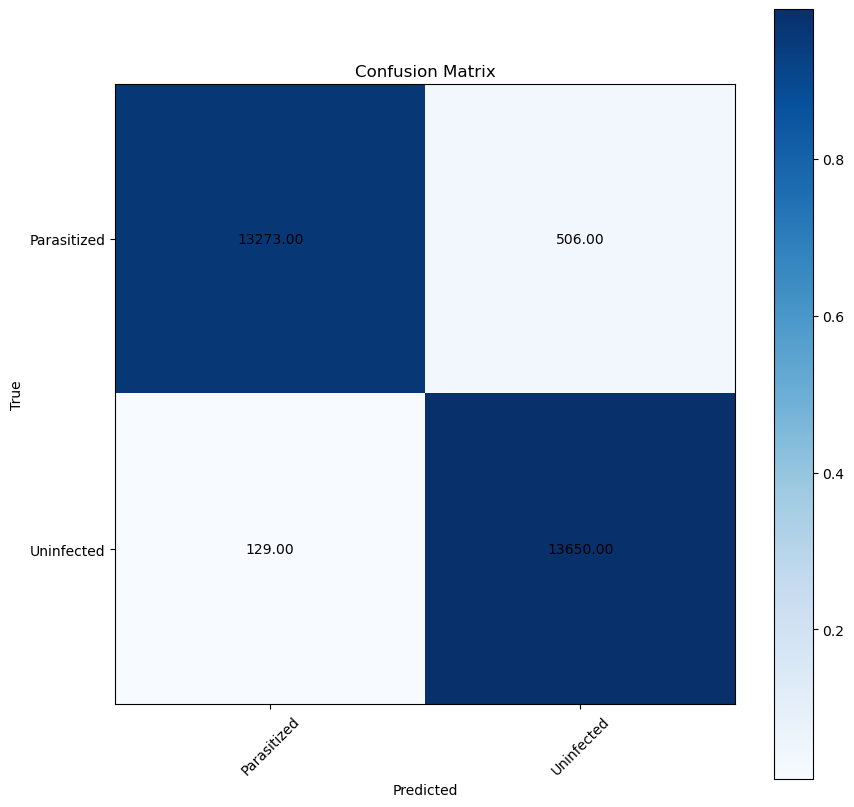

In [49]:
import torch
import torch.nn.functional as F


def compute_confusion_matrix(model, dataloader):
    device = ("cuda" if torch.cuda.is_available else "cpu")
    model.to(device)
    num_classes = len(dataloader.dataset.classes)
    confusion_matrix = torch.zeros(num_classes, num_classes)
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(train_ds):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            predicted = torch.max(outputs, 1)[1]
            for true_label, predicted_label in zip(labels, predicted):
                confusion_matrix[true_label][predicted_label] += 1

    return confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(confusion_matrix, class_names):
    confusion_matrix = confusion_matrix.numpy()
    normalized_matrix = confusion_matrix / confusion_matrix.sum(axis=1, keepdims=True)
    
    fig, ax = plt.subplots(figsize=(10, 10))
    
    im = ax.imshow(normalized_matrix, cmap='Blues')
    
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names, rotation=45)
    ax.set_yticklabels(class_names)
    
    cbar = ax.figure.colorbar(im, ax=ax)
    
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title('Confusion Matrix')
    
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            text = ax.text(j, i, f'{confusion_matrix[i, j]:.2f}',
                           ha='center', va='center', color='black')
    
    # Show the plot
    plt.show()
# Assuming you have a trained model and a dataloader
batch_size=1000

testing_set = DataLoader(testing_set, batch_size, shuffle=True,)

confusion_matrix = compute_confusion_matrix(model, testing_set)

# Assuming you have a list of class names
class_names = train_dataset.classes

# Plot the confusion matrix
plot_confusion_matrix(confusion_matrix, class_names)


In [58]:

loaded_model = torch.load('model.pth')

In [64]:
 from PIL import Image
    


image = Image.open('/kaggle/input/files1/Malaria Cells/testing_set/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_162.png')
image = transform(image).unsqueeze(0)  # Add batch dimension
image = image.to(device)
output = loaded_model(image)
_, predicted = torch.max(output, 1)
predicted_label = predicted.item() 
print(class_labels[predicted_label])# Get the predicted label as an integer

Parasitized


In [65]:
 from PIL import Image
    


image = Image.open('/kaggle/input/files1/Malaria Cells/testing_set/Uninfected/C100P61ThinF_IMG_20150918_144104_cell_21.png')
image = transform(image).unsqueeze(0)  # Add batch dimension
image = image.to(device)
output = loaded_model(image)
_, predicted = torch.max(output, 1)
predicted_label = predicted.item() 
print(class_labels[predicted_label])# Get the predicted label as an integer

Uninfected
